In [2]:
print([i for i in range(12)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Pregunta: Explica la analog´ıa, bajo un enfoque evolutivo, al implementar
un algoritmo de b´usqueda local dentro de cada generaci´on de un algoritmo
evolutivo. ¿C´omo influye este enfoque en la exploraci´on y explotaci´on del espacio
de soluciones? Proporciona un ejemplo en el que la integraci´on de b´usqueda local
mejore el rendimiento de un algoritmo evolutivo.

Un algoritmo evolutivo, utiliza una población de soluciones para explorar el espacio de soluciones. En cada generación, se seleccionan los mejores individuos de la población y se modifican su genotipo para generar una nueva generación. El proceso se repite varias veces hasta alcanzar un objetivo específico.

En cambio, el algoritmo de búsqueda local es un método de optimización local que se centra en una pequeña área del espacio de soluciones a fin de encontrar la mejor solución posible en ese área. La búsqueda local se utiliza dentro de un algoritmo evolutivo para combinar la búsqueda aleatoria del algoritmo evolutivo con la búsqueda local en un área específica.

En el caso de Simulated Annealing, la integración de un algoritmo de búsqueda local en cada generación de un algoritmo evolutivo se puede ver como un proceso de enfriamiento adaptativo aplicado a cada individuo.

En la evolución natural, los organismos no solo se reproducen y mutan, sino que también experimentan pequeños ajustes adaptativos antes de transmitir sus genes. SA imita este proceso al permitir que cada solución refine su calidad mediante cambios locales, aceptando ocasionalmente soluciones peores para evitar el atrapamiento en óptimos locales. 

En el estado inicial la temperatura es alta, y se podria considerar como la fase exploratoria que brindan los organismos, mientras que cuando la temperatura se enfria, se transiciona a una fase de explotacion local y se busca los minimos locales en cada vecindad de organismos, cuando la entropia es baja, significa que ya hemos encontrado los minimos locales y se elige al mejor de la generacion como resultado. 


Multi-Point + XOR best solution found at :
[ 0.02945435 -0.05115754 -1.00935418  0.86474706 -0.02600207  0.00790521
  0.0266187  -0.06659628 -0.07563343  0.02540959]
fitness=8.264345092663106

Multi-Point + Gaussian best solution found at :
[ 0.98114295 -0.00442813  0.00685622  1.00118889 -1.00604428  0.99184002
  0.99303072 -1.99560136  1.99554266  0.998084  ]
fitness=14.029793114292389

Multi-Point + Polynomial best solution found at :
[ 0.01054134  1.97582151  0.99412376  0.00319255  1.00656842 -0.97873925
  0.00502399 -0.03500481 -0.03184967 -0.03806369]
fitness=7.840710063601833

BLX-α + XOR best solution found at :
[ 1.92590914e-05 -6.61281886e-05  2.73894484e-05 -9.94938347e-01
 -9.94964902e-01  9.94913917e-01  8.34744793e-06  9.94990871e-01
 -7.49452970e-05  1.20877785e-04]
fitness=3.9798420373116272

BLX-α + Gaussian best solution found at :
[ 2.09818482e-06  1.32155320e-05  9.94984017e-01 -6.96346503e-05
  1.05185411e-05  4.04955655e-05  2.37632373e-05  1.26499171e-05
 -5.019

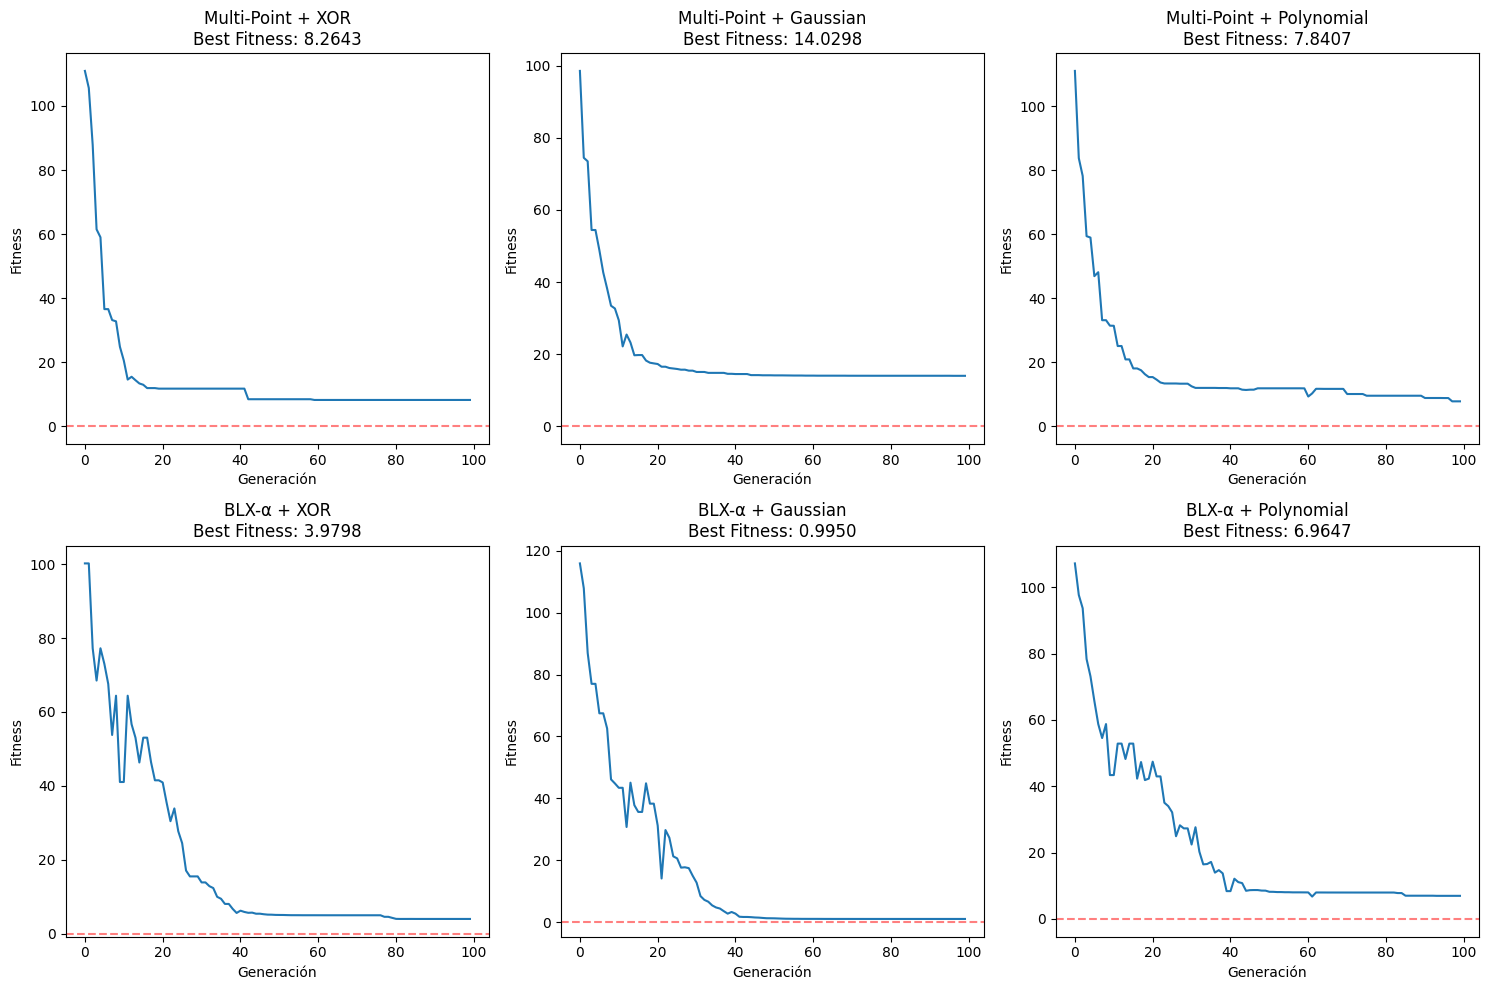

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

def rastrigin_function(x: np.ndarray) -> float:
    """
    Función Rastrigin de 10 dimensiones.
    """
    n = len(x)
    return 10 * n + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

class GeneticAlgorithm:
    def __init__(self, population_size=100, dimensions=10, max_generations=100,
                 crossover_rate=0.8, mutation_rate=0.1):
        self.population_size = population_size
        self.dimensions = dimensions
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.lower_bound = -5.12
        self.upper_bound = 5.12
        self.population = self._initialize_population()
        self.mutate = None  # Se asignará dinámicamente

    def _initialize_population(self) -> List[np.ndarray]:
        return [np.random.uniform(self.lower_bound, self.upper_bound, self.dimensions)
                for _ in range(self.population_size)]
    
    def _fitness(self, individual: np.ndarray) -> float:
        return rastrigin_function(individual)
    
    def selection(self, population: List[np.ndarray], fitness_values: List[float]) -> List[np.ndarray]:
        selected = []
        for _ in range(len(population)):
            tournament = random.sample(list(zip(population, fitness_values)), 3)
            winner = min(tournament, key=lambda x: x[1])[0]
            selected.append(winner.copy())
        return selected
    
    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError("Subclases deben implementar crossover()")
    
    def run(self) -> Tuple[np.ndarray, float, List[float]]:
        best_fitness_history = []
        for _ in range(self.max_generations):
            fitness_values = [self._fitness(ind) for ind in self.population]
            best_idx = np.argmin(fitness_values)
            best_individual = self.population[best_idx]
            best_fitness = fitness_values[best_idx]
            best_fitness_history.append(best_fitness)
            selected_population = self.selection(self.population, fitness_values)
            next_population = []
            for i in range(0, len(selected_population), 2):
                if i + 1 < len(selected_population) and random.random() < self.crossover_rate:
                    child1, child2 = self.crossover(selected_population[i], selected_population[i+1])
                    next_population.extend([child1, child2])
                else:
                    next_population.extend([selected_population[i], 
                                            selected_population[i+1] if i+1 < len(selected_population) else selected_population[i]])
            self.population = [self.mutate(ind) if random.random() < self.mutation_rate else ind for ind in next_population]
        return best_individual, best_fitness, best_fitness_history

class MultiPointCrossover(GeneticAlgorithm):
    def crossover(self, parent1, parent2):
        child1, child2 = parent1.copy(), parent2.copy()
        points = sorted(random.sample(range(len(parent1)), 2))
        child1[points[0]:points[1]] = parent2[points[0]:points[1]]
        child2[points[0]:points[1]] = parent1[points[0]:points[1]]
        return child1, child2

class BLXAlphaCrossover(GeneticAlgorithm):
    def __init__(self, alpha=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
    
    def crossover(self, parent1, parent2):
        child1, child2 = np.zeros_like(parent1), np.zeros_like(parent2)
        for i in range(len(parent1)):
            min_val, max_val = min(parent1[i], parent2[i]), max(parent1[i], parent2[i])
            range_val = max_val - min_val
            lower, upper = max(self.lower_bound, min_val - self.alpha * range_val), min(self.upper_bound, max_val + self.alpha * range_val)
            child1[i], child2[i] = np.random.uniform(lower, upper), np.random.uniform(lower, upper)
        return child1, child2

class XORMutation:
    def __call__(self, individual):
        mutated = individual.copy()
        mask = np.random.random(len(individual)) < 0.1
        mutated[mask] = np.random.uniform(-5.12, 5.12, np.sum(mask))
        return mutated

class GaussianMutation:
    def __init__(self, sigma=0.1):
        self.sigma = sigma
    
    def __call__(self, individual):
        mutated = individual.copy()
        mask = np.random.random(len(individual)) < 0.1
        mutated[mask] += np.random.normal(0, self.sigma, np.sum(mask))
        return np.clip(mutated, -5.12, 5.12)

class PolynomialMutation:
    def __init__(self, eta=20):
        self.eta = eta
    
    def __call__(self, individual):
        mutated = individual.copy()
        mask = np.random.random(len(individual)) < 0.1
        for i in range(len(mutated)):
            if mask[i]:
                u = np.random.random()
                delta = (2 * u) ** (1 / (self.eta + 1)) - 1 if u < 0.5 else 1 - (2 * (1 - u)) ** (1 / (self.eta + 1))
                mutated[i] += delta * (5.12 - (-5.12))
        return np.clip(mutated, -5.12, 5.12)

def run_experiments():
    experiments = [
        (MultiPointCrossover, XORMutation, "Multi-Point + XOR"),
        (MultiPointCrossover, GaussianMutation, "Multi-Point + Gaussian"),
        (MultiPointCrossover, PolynomialMutation, "Multi-Point + Polynomial"),
        (BLXAlphaCrossover, XORMutation, "BLX-α + XOR"),
        (BLXAlphaCrossover, GaussianMutation, "BLX-α + Gaussian"),
        (BLXAlphaCrossover, PolynomialMutation, "BLX-α + Polynomial")
    ]
    
    plt.figure(figsize=(15, 10))
    for i, (crossover_class, mutation_class, label) in enumerate(experiments, 1):
        ga = crossover_class()
        ga.mutate = mutation_class()
        best_solution, best_fitness, fitness_history = ga.run()
        print(f"{label} best solution found at :\n{best_solution}\nfitness={best_fitness}\n")
        plt.subplot(2, 3, i)
        plt.plot()
        plt.plot(fitness_history)
        plt.axhline(y=0, linestyle='--', color='red', alpha=0.5)
        plt.title(f'{label}\nBest Fitness: {best_fitness:.4f}')
        plt.xlabel('Generación')
        plt.ylabel('Fitness')
    plt.tight_layout()
    plt.show()

run_experiments()


Los algoritmos evolutivos deben equilibrar exploración (buscar en diferentes regiones del espacio de búsqueda) y explotación (refinar soluciones prometedoras). Este equilibrio depende de los operadores de cruce y mutación.

#### Exploración:
Se logra con mutaciones agresivas que generan diversidad, como la mutación XOR.
Cruces que producen soluciones ampliamente diferentes, como BLX-α y SBX.

#### Explotación:
Se mejora con mutaciones suaves, como la mutación Gaussiana o Polinomial, que ajustan valores sin cambios drásticos.
Cruces que combinan características locales efectivas, como Multi-Point.

Un buen balance entre exploración y explotación previene la convergencia prematura en óptimos locales y mejora la calidad de la solución.

#### Tecnica avanzada:
Un enfoque mejorado sería Self-Adaptive Mutation, donde la tasa de mutación varía dinámicamente:
Alta en las primeras generaciones (mayor exploración).
Baja en las últimas generaciones (mayor explotación).

También se podría emplear hibridación con Gradiente Descendente en las últimas generaciones para refinar la solución óptima.

### Tercera seccion: recreacion de imagen


Luego de varias pruebas, mi algoritmo es extremadamente lento, no pude correrlo mas de 6 veces, tuve varios problemas para el manejo de los colores bgr a rgb y no me daba cuenta hasta que terminaban las generaciones, pero la calidad de las imagenes es bastante buena, con un tuneo mas preciso de parametros y una optimizacion, se podria llegar a un mejor algoritmo pero me parece bastante bueno.